# Tutorial: Generating a CSM Camera Model from PDS Image in Knoten with Basic Camera Operations

## 1. Prerequisites

### Install Knoten
This tutorial requires Knoten version 0.4 or higher.

`conda install -c conda-forge knoten=0.4`

### Install Matplotlib
This tutorial requires matplotlib.

`conda install -c conda-forge matplotlib`

## 2. Create a CSM camera for a PDS image

In [ ]:
import os
import json
import shapely.wkt
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from csmapi import csmapi
import pandas as pd

import ale
from knoten import csm, sensor_utils
from knoten.shape import Ellipsoid
from knoten.illuminator import Illuminator

## 3. Download the image from the PDS archives

In [ ]:
data_dir = '../data/image_to_ground'
filename = os.path.join(data_dir, "B10_013341_1010_XN_79S172W.IMG")

downloader = urllib.request.URLopener()
downloader.retrieve("https://asc-pds-mars-reconnaissance-orbiter.s3.us-west-2.amazonaws.com/CTX/mrox_0826/data/B10_013341_1010_XN_79S172W.IMG", filename)

## 4. Set Ale SPICE Data Area
If an ale driver is going to be used that leverages SPICE data, it is necessary to set the ALESPICEROOT.

For this example, the necessary SPICE data is preselected. In most cases, you do not know what kernels are needed for a particular image.  

To set your spice area, one can do this using normal shell syntax, e.g.:

`export ALESPICEROOT=/path/to/ale/spice`

or inside of a conda environment:

`conda env config vars set ALESPICEROOT=/path/to/ale/spice.`

See instructions for installing SPICE data [here](https://github.com/DOI-USGS/ISIS3?tab=readme-ov-file#full-isis-data-download).

In [3]:
props = {
    'kernels': [
        os.path.join(data_dir, 'B10_013341_1010_XN_79S172W_0.bsp'),
        os.path.join(data_dir, 'B10_013341_1010_XN_79S172W_1.bsp'),
        os.path.join(data_dir, 'mro_ctx_v11.ti'),
        os.path.join(data_dir, 'mro_sc_psp_090526_090601_0_sliced_-74000.bc'),
        os.path.join(data_dir, 'mro_sc_psp_090526_090601_1_sliced_-74000.bc'),
        os.path.join(data_dir, 'mro_sclkscet_00082_65536.tsc'),
        os.path.join(data_dir, 'mro_v16.tf'),
        os.path.join(data_dir, 'naif0012.tls'),
        os.path.join(data_dir, 'pck00008.tpc')
    ]
}

## 5. Generate and Write an Ale ISD

In [ ]:
isd_string = ale.loads(filename, props=props)
csm_isd = os.path.splitext(filename)[0] + '.json'

with open(csm_isd, 'w') as isd_file:
    isd_file.write(isd_string)

## 6. Create a CSM Camera Model from ISD

In [5]:
camera = csm.create_csm(csm_isd)

## 7. Get the footprint using the camera model and plot it

Text(0.5, 1.0, 'CSM footprint')

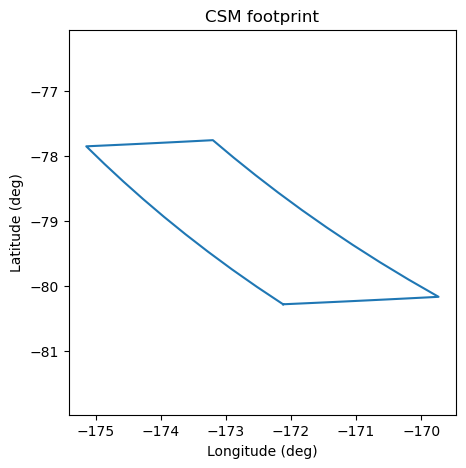

In [6]:
with open(csm_isd, 'r') as fp:
    aledict = json.load(fp)

nlines, nsamples = aledict["image_lines"], aledict["image_samples"]

boundary = csm.generate_boundary((nlines, nsamples))

lons, lats, alts = csm.generate_latlon_boundary(camera, boundary)

plt.rcParams["figure.figsize"] = [5, 5]
plt.axes().set_aspect('equal','datalim')
plt.plot(lons, lats)
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("CSM footprint")

Text(0.5, 1.0, 'Body Fixed Footprint')

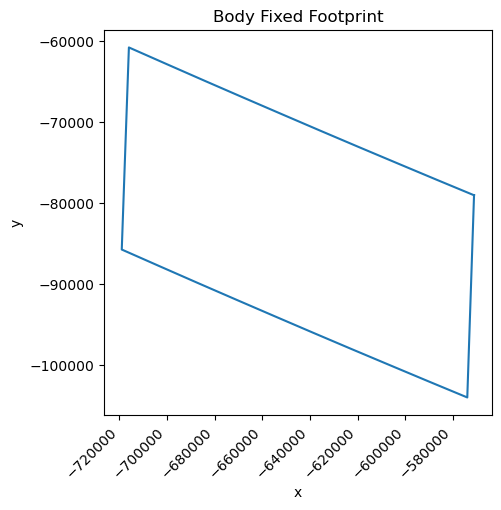

In [7]:
bodyfixed_footprint = csm.generate_bodyfixed_footprint(camera, boundary)

csm_wkt = bodyfixed_footprint.ExportToWkt()

csm_geom = shapely.wkt.loads(csm_wkt)
csm_x, csm_y = csm_geom.geoms[0].exterior.coords.xy

plt.xlabel("x")
plt.ylabel("y")
plt.plot(csm_x, csm_y)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
)
plt.title("Body Fixed Footprint")

## 8. Get Camera Info at an Image Point

In [8]:
image_pt = csmapi.ImageCoord(nlines/2, nsamples/2)
shape = Ellipsoid.from_csm_sensor(camera)
illuminator = Illuminator()

In [9]:
caminfo = {
    "PhaseAngle": sensor_utils.phase_angle(image_pt, camera, shape, illuminator),
    "EmissionAngle": sensor_utils.emission_angle(image_pt, camera, shape),
    "SlantDistance": sensor_utils.slant_distance(image_pt, camera, shape),
    "TargetCenterDistance": sensor_utils.target_center_distance(image_pt, camera),
    "SubSpacecraftLatitude": sensor_utils.sub_spacecraft_point(image_pt, camera).lat,
    "SubSpacecraftLongitude": sensor_utils.sub_spacecraft_point(image_pt, camera).lon,
    "LocalRadius": sensor_utils.local_radius(image_pt, camera, shape),
    "RightAscension": sensor_utils.right_ascension_declination(image_pt, camera)[0],
    "Declination": sensor_utils.right_ascension_declination(image_pt, camera)[1],
    "LineResolution": sensor_utils.line_resolution(image_pt, camera, shape),
    "SampleResolution": sensor_utils.sample_resolution(image_pt, camera, shape),
    "PixelResolution": sensor_utils.pixel_resolution(image_pt, camera, shape),
}

caminfo

129387.64878271958
251123.7546265136


{'PhaseAngle': 58.986916499957154,
 'EmissionAngle': 0.10161336902837881,
 'SlantDistance': 251124.1495516768,
 'TargetCenterDistance': 3628059.1980234315,
 'SubSpacecraftLatitude': -78.89842320708418,
 'SubSpacecraftLongitude': 187.2644730283536,
 'LocalRadius': 3376935.3088204544,
 'RightAscension': 6.933803726271131,
 'Declination': 78.9463718229981,
 'LineResolution': 6.0485566304149945,
 'SampleResolution': 5.017404463546378,
 'PixelResolution': 5.532980546980687}